<a href="https://colab.research.google.com/github/AbeerProg/RRDS/blob/main/LSTMandCNN_Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Ensure NLTK resources are downloaded
nltk.download('punkt')

# ------------------------------
# 1. Load and Preprocess the Dataset
# ------------------------------

df = pd.read_excel("/content/AuDS.xlsx")
df.columns = df.columns.str.strip()  # Clean column names

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

# Assume columns: ['text', 'PM Ratio', 'FPSP Ratio', 'Review Length', 'RW Ratio',
#                  'Sentiment', 'Generalization', 'Passive Voice', 'Total reviewer reviews',
#                  'Account type', 'Useful votes', 'Attached Medias', 'label']
text_col = "text"
label_col = "label"
numeric_cols = df.columns.tolist()[1:-1]  # All columns between text and label

# Preprocess text: tokenize and pad
max_words = 5000    # vocabulary size
max_len = 100       # reduce sequence length for speed

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[text_col].astype(str))
X_text = tokenizer.texts_to_sequences(df[text_col].astype(str))
X_text = pad_sequences(X_text, maxlen=max_len)

# Preprocess numeric features: convert and scale
X_numeric = df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Get labels
y = df[label_col].values

# Split dataset (80% train, 20% test)
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric_scaled, y, test_size=0.2, random_state=42
)

In [ ]:

# ------------------------------
# 2. Define a Faster LSTM Model
# ------------------------------

def build_lstm_model():
    # Text branch: Embedding -> LSTM
    text_input = Input(shape=(max_len,), name="text_input")
    x = Embedding(input_dim=max_words, output_dim=50, input_length=max_len)(text_input)
    x = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(x)

    # Numeric branch: simple Dense
    num_input = Input(shape=(X_train_num.shape[1],), name="num_input")
    y_num = Dense(16, activation="relu")(num_input)

    # Combine branches
    combined = Concatenate()([x, y_num])
    combined = Dense(16, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation="sigmoid")(combined)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 50)        │        250,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 11)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │         10,624 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │            192 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 48)             │              0 │ lstm[0][0],            │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            784 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             17 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 261,617 (1021.94 KB)

 Trainable params: 261,617 (1021.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# ------------------------------
# 3. Define a Faster CNN Model
# ------------------------------

def build_cnn_model():
    # Text branch: Embedding -> Conv1D -> GlobalMaxPooling1D
    text_input = Input(shape=(max_len,), name="text_input")
    x = Embedding(input_dim=max_words, output_dim=50, input_length=max_len)(text_input)
    x = Conv1D(32, kernel_size=3, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)

    # Numeric branch: simple Dense
    num_input = Input(shape=(X_train_num.shape[1],), name="num_input")
    y_num = Dense(16, activation="relu")(num_input)

    # Combine branches
    combined = Concatenate()([x, y_num])
    combined = Dense(16, activation="relu")(combined)
    combined = Dropout(0.3)(combined)
    output = Dense(1, activation="sigmoid")(combined)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100, 50)        │        250,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 98, 32)         │          4,832 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 11)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 32)             │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            192 │ num_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 48)             │              0 │ global_max_pooling1d[… │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │            784 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             17 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 255,825 (999.32 KB)

 Trainable params: 255,825 (999.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------
# 4. Train Both Models and Compare
# ------------------------------

# Early stopping to avoid overfitting and reduce training time
early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# Train LSTM model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    [X_train_text, X_train_num], y_train,
    epochs=3, batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate LSTM model
lstm_loss, lstm_acc = lstm_model.evaluate([X_test_text, X_test_num], y_test, verbose=0)
print(f"LSTM Model Test Accuracy: {lstm_acc:.2f}")

# Train CNN model
print("\nTraining CNN model...")
cnn_history = cnn_model.fit(
    [X_train_text, X_train_num], y_train,
    epochs=3, batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate CNN model
cnn_loss, cnn_acc = cnn_model.evaluate([X_test_text, X_test_num], y_test, verbose=0)
print(f"CNN Model Test Accuracy: {cnn_acc:.2f}")


Training LSTM model...
Epoch 1/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 78s 62ms/step - accuracy: 0.7961 - loss: 0.4122 - val_accuracy: 0.9190 - val_loss: 0.1993
Epoch 2/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.9267 - loss: 0.1821 - val_accuracy: 0.9452 - val_loss: 0.1418
Epoch 3/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 73s 60ms/step - accuracy: 0.9541 - loss: 0.1224 - val_accuracy: 0.9594 - val_loss: 0.1114
LSTM Model Test Accuracy: 0.96

Training CNN model...
Epoch 1/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8009 - loss: 0.4111 - val_accuracy: 0.9225 - val_loss: 0.1942
Epoch 2/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9412 - loss: 0.1573 - val_accuracy: 0.9554 - val_loss: 0.1192
Epoch 3/3
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9786 - loss: 0.0679 - val_accuracy: 0.9674 - val_loss: 0.0919
CNN Model Test Accuracy: 0.97


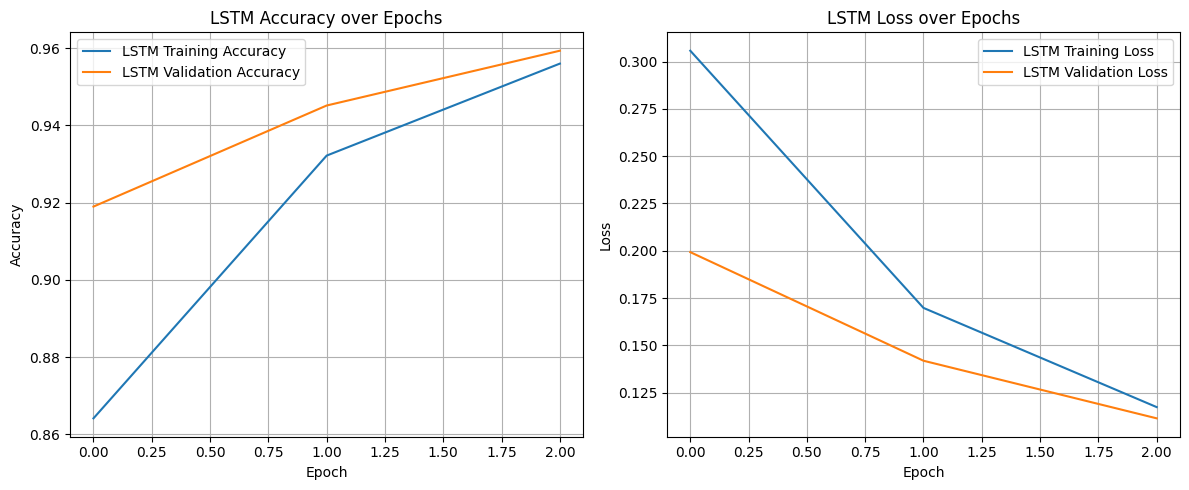

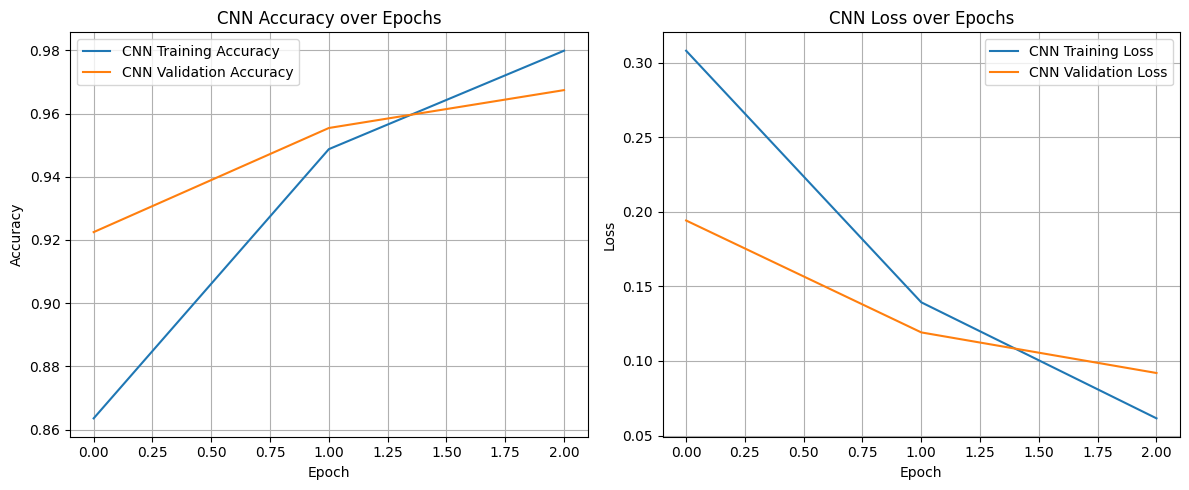

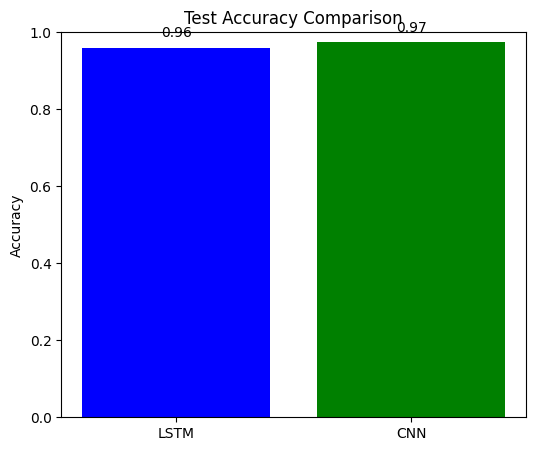

In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# Plotting Training and Validation Curves for LSTM
# ------------------------------
plt.figure(figsize=(12,5))

# LSTM Accuracy
plt.subplot(1,2,1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('LSTM Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# LSTM Loss
plt.subplot(1,2,2)
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------
# Plotting Training and Validation Curves for CNN
# ------------------------------
plt.figure(figsize=(12,5))

# CNN Accuracy
plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# CNN Loss
plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------------
# Compare Final Test Accuracies Using a Bar Plot
# ------------------------------

models = ['LSTM', 'CNN']
test_accuracies = [lstm_acc, cnn_acc]

plt.figure(figsize=(6,5))
bars = plt.bar(models, test_accuracies, color=['blue', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.show()


672/672 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     12558
           1       0.95      0.95      0.95      8918

    accuracy                           0.96     21476
   macro avg       0.96      0.96      0.96     21476
weighted avg       0.96      0.96      0.96     21476



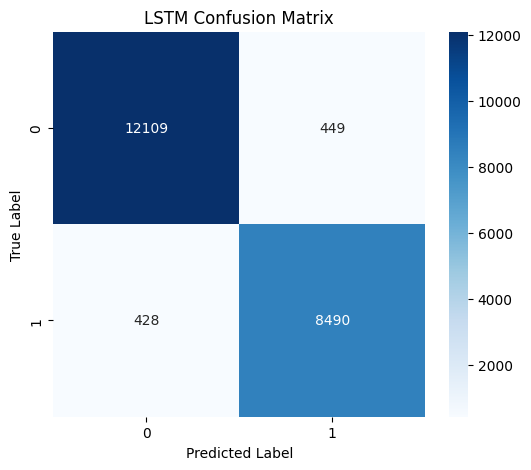

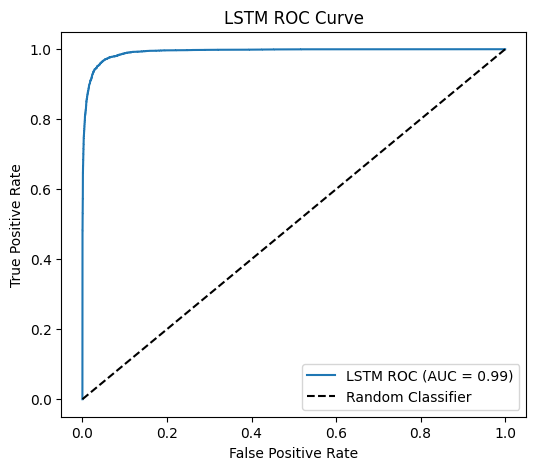

672/672 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     12558
           1       0.96      0.98      0.97      8918

    accuracy                           0.97     21476
   macro avg       0.97      0.97      0.97     21476
weighted avg       0.97      0.97      0.97     21476



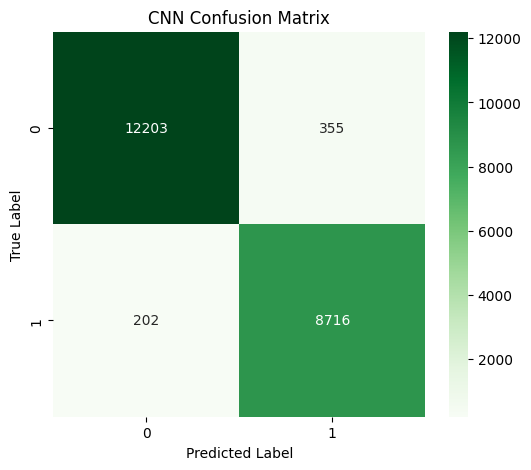

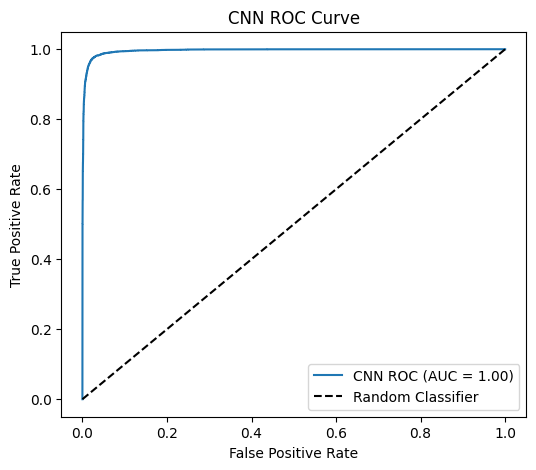

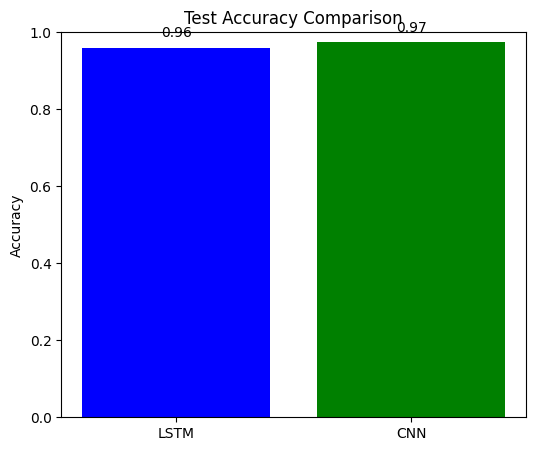

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ------------------------------
# Evaluate LSTM Model
# ------------------------------
# Get predicted probabilities and convert to class predictions
lstm_probs = lstm_model.predict([X_test_text, X_test_num]).ravel()
lstm_pred = (lstm_probs > 0.5).astype(int)

# Print classification report for LSTM
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_pred))

# Plot Confusion Matrix for LSTM
lstm_cm = confusion_matrix(y_test, lstm_pred)
plt.figure(figsize=(6,5))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_probs)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(6,5))
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM ROC (AUC = {roc_auc_lstm:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend(loc='lower right')
plt.show()

# ------------------------------
# Evaluate CNN Model
# ------------------------------
# Get predicted probabilities and class predictions for CNN
cnn_probs = cnn_model.predict([X_test_text, X_test_num]).ravel()
cnn_pred = (cnn_probs > 0.5).astype(int)

# Print classification report for CNN
print("CNN Classification Report:")
print(classification_report(y_test, cnn_pred))

# Plot Confusion Matrix for CNN
cnn_cm = confusion_matrix(y_test, cnn_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Greens')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_probs)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(6,5))
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN ROC (AUC = {roc_auc_cnn:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CNN ROC Curve")
plt.legend(loc='lower right')
plt.show()

# ------------------------------
# Compare Final Test Accuracies with a Bar Chart
# ------------------------------
# Evaluate test performance (if not already done) to get final accuracy values
lstm_loss, lstm_acc = lstm_model.evaluate([X_test_text, X_test_num], y_test, verbose=0)
cnn_loss, cnn_acc = cnn_model.evaluate([X_test_text, X_test_num], y_test, verbose=0)

models = ['LSTM', 'CNN']
accuracies = [lstm_acc, cnn_acc]

plt.figure(figsize=(6,5))
bars = plt.bar(models, accuracies, color=['blue', 'green'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)

# Annotate the bars with the accuracy values
for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, y_val + 0.02, f"{y_val:.2f}", ha='center', va='bottom')

plt.show()
